# Forest Plot

> Explanation of how to use forest_plot to compare contrast objects such as delta-delta and mini-meta using DABEST.

- order: 5

Version 2023.02.14, DABEST also supports the comparison and analysis of different delta-delta analysis through a function called "forest_plot". 

Many experimental designs investigate the effects of two interacting independent variables on a dependent variable. The delta-delta effect size enables us distill the net effect of the two variables. To illustrate this, let's explore the following  problem. 

Consider 3 experiments where in each of the experiment we test the efficacy of a two different factors "lightEffect" and "genotypeEffect" named ``Drug`` on a disease-causing mutation ``M`` based on disease metric ``Y``. The greater the value ``Y`` has, the more severe the disease phenotype is. Phenotype ``Y`` has been shown to be caused by a gain-of-function mutation ``M``, so we expect a difference between wild type (``W``) subjects and mutant subjects (``M``). Now, we want to know whether this effect is ameliorated by the administration of ``Drug`` treatment. We also administer a placebo as a control. In theory, we only expect ``Drug`` to have an effect on the ``M`` group, although in practice, many drugs have non-specific effects on healthy populations too.

Effectively, we have 3 sets of four-groups-subject comparison where each of the factors are in different levels for different experimental design.

We can also compare delta-delta analysis amongst different experiments or different factors. In this tutorial we will demonstrate 3 similar experiments where their "Y" values differ from each other due to different experimental settings or "Drug" used.

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug  | X<sub>D, W</sub> | X<sub>D, M</sub> |
| Placebo | X<sub>P, W</sub> | X<sub>P, M</sub> |

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug2  | X<sub>D, W</sub> | X<sub>D, M</sub> |
| Placebo | X<sub>P, W</sub> | X<sub>P, M</sub> |

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug3  | X<sub>D, W</sub> | X<sub>D, M</sub> |
| Placebo | X<sub>P, W</sub> | X<sub>P, M</sub> |

There are two ``Treatment`` conditions, ``Placebo`` (control group) and ``Drug`` (test group). There are two ``Genotype``\s: ``W`` (wild type population) and ``M`` (mutant population). Additionally, each experiment was conducted twice (``Rep1`` and ``Rep2``). We will perform several analyses to visualise these differences in a simulated dataset. 

Inputs: 
1. A list of contrast objects (maybe also their names? to be used in the x-tick labels)
2. Which effect size to plot (prioritise code working for delta-delta mean-diff)
3. axes to put the plot into 

output: 
A plot with horizontally laid out half violin plots of each of the prescribed delta bootstraps. 


## Load libraries

In [ ]:
import numpy as np
import pandas as pd
import dabest
from dabest.forest_plot import forest_plot
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
import dabest 
print("We're using DABEST v{}".format(dabest.__version__))

We're using DABEST v2023.03.29


## Simulate a few datasets to get the contrast objects

In [ ]:
from scipy.stats import norm # Used in generation of populations.
np.random.seed(9999) # Fix the seed to ensure reproducibility of results.

# Create samples
N = 20
y = norm.rvs(loc=3, scale=0.4, size=N*4)
y[N:2*N] = y[N:2*N]+1
y[2*N:3*N] = y[2*N:3*N]-0.5

# Add a `Treatment` column
t1 = np.repeat('Placebo', N*2).tolist()
t2 = np.repeat('Drug', N*2).tolist()
treatment = t1 + t2 

# Add a `Rep` column as the first variable for the 2 replicates of experiments done
rep = []
for i in range(N*2):
    rep.append('Rep1')
    rep.append('Rep2')

# Add a `Genotype` column as the second variable
wt = np.repeat('W', N).tolist()
mt = np.repeat('M', N).tolist()
wt2 = np.repeat('W', N).tolist()
mt2 = np.repeat('M', N).tolist()


genotype = wt + mt + wt2 + mt2

# Add an `id` column for paired data plotting.
id = list(range(0, N*2))
id_col = id + id 


# Combine all columns into a DataFrame.
df_delta2_drug1 = pd.DataFrame({'ID'        : id_col,
                  'Rep'      : rep,
                   'Genotype'  : genotype, 
                   'Treatment': treatment,
                   'Y'         : y
                })

np.random.seed(33) 

# Create samples
N = 20
y = norm.rvs(loc=3, scale=0.4, size=N*4)
y[N:2*N] = y[N:2*N]+0.1
y[2*N:3*N] = y[2*N:3*N]-1

# Add a `Treatment` column
t1 = np.repeat('Placebo', N*2).tolist()
t2 = np.repeat('Drug', N*2).tolist()
treatment = t1 + t2 

# Add a `Rep` column as the first variable for the 2 replicates of experiments done
rep = []
for i in range(N*2):
    rep.append('Rep1')
    rep.append('Rep2')

# Add a `Genotype` column as the second variable
wt = np.repeat('W', N).tolist()
mt = np.repeat('M', N).tolist()
wt2 = np.repeat('W', N).tolist()
mt2 = np.repeat('M', N).tolist()


genotype = wt + mt + wt2 + mt2

# Add an `id` column for paired data plotting.
id = list(range(0, N*2))
id_col = id + id 


# Combine all columns into a DataFrame.
df_delta2_drug2 = pd.DataFrame({'ID'        : id_col,
                  'Rep'      : rep,
                   'Genotype'  : genotype, 
                   'Treatment': treatment,
                   'Y'         : y
                })

from scipy.stats import norm # Used in generation of populations.
np.random.seed(9999) # Fix the seed to ensure reproducibility of results.

# Create samples
N = 20
y = norm.rvs(loc=3, scale=0.4, size=N*4)
y[N:2*N] = y[N:2*N]+3
y[2*N:3*N] = y[2*N:3*N]-0.1

# Add a `Treatment` column
t1 = np.repeat('Placebo', N*2).tolist()
t2 = np.repeat('Drug', N*2).tolist()
treatment = t1 + t2 

# Add a `Rep` column as the first variable for the 2 replicates of experiments done
rep = []
for i in range(N*2):
    rep.append('Rep1')
    rep.append('Rep2')

# Add a `Genotype` column as the second variable
wt = np.repeat('W', N).tolist()
mt = np.repeat('M', N).tolist()
wt2 = np.repeat('W', N).tolist()
mt2 = np.repeat('M', N).tolist()


genotype = wt + mt + wt2 + mt2

# Add an `id` column for paired data plotting.
id = list(range(0, N*2))
id_col = id + id 


# Combine all columns into a DataFrame.
df_delta2_drug3 = pd.DataFrame({'ID'        : id_col,
                  'Rep'      : rep,
                   'Genotype'  : genotype, 
                   'Treatment': treatment,
                   'Y'         : y
                })

In [ ]:
df_delta2_drug1[3*N:4*N]

,ID,Rep,Genotype,Treatment,Y
60,20,Rep1,M,Drug,2.936700
61,21,Rep2,M,Drug,2.974378
62,22,Rep1,M,Drug,3.701743
63,23,Rep2,M,Drug,3.851824
64,24,Rep1,M,Drug,2.776046
65,25,Rep2,M,Drug,2.673809
66,26,Rep1,M,Drug,2.859561
67,27,Rep2,M,Drug,2.652092
68,28,Rep1,M,Drug,2.988987
69,29,Rep2,M,Drug,2.822536


### Creating contrast objects that is required for forest_plot and they are basically dabest objects with ``delta2 = True``

In [ ]:
unpaired_delta_01 = dabest.load(data = df_delta2_drug1, 
                                x = ["Genotype", "Genotype"], 
                                y = "Y", delta2 = True, 
                                experiment = "Treatment")
unpaired_delta_02 = dabest.load(data = df_delta2_drug2, 
                                x = ["Genotype", "Genotype"], 
                                y = "Y", delta2 = True, 
                                experiment = "Treatment")
unpaired_delta_03 = dabest.load(data = df_delta2_drug3, 
                                x = ["Genotype", "Genotype"], 
                                y = "Y", 
                                delta2 = True, 
                                experiment = "Treatment")
paired_delta_01 = dabest.load(data = df_delta2_drug1, 
                                paired = "baseline", id_col="ID",
                                x = ["Treatment", "Rep"], y = "Y", 
                                delta2 = True, experiment = "Genotype")
paired_delta_02 = dabest.load(data = df_delta2_drug2,
                                paired = "baseline", id_col="ID",
                                x = ["Treatment", "Rep"], y = "Y", 
                                delta2 = True, experiment = "Genotype")
paired_delta_03 = dabest.load(data = df_delta2_drug3,
                                paired = "baseline", id_col="ID",
                                x = ["Treatment", "Rep"], y = "Y", 
                                delta2 = True, experiment = "Genotype")
contrasts = [unpaired_delta_01, unpaired_delta_02, unpaired_delta_03]
paired_contrasts = [paired_delta_01, paired_delta_02, paired_delta_03]

## Visualize the delta delta plots for each synthesized datasets with dabest.mean_diff.plot

To create a delta-delta plot, you simply need to set ``delta2=True`` in the 
``dabest.load()`` function. However, in this case,``x`` needs to be declared as a list consisting of 2 elements, unlike most cases where it is a single element. The first element in ``x`` will represent the variable plotted along the horizontal axis, and the second one will determine the color of dots for scattered plots or the color of lines for slope graphs. We use the ``experiment`` input to specify the grouping of the data.

/Users/wangzhuoyulucas/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/wangzhuoyulucas/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/wangzhuoyulucas/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


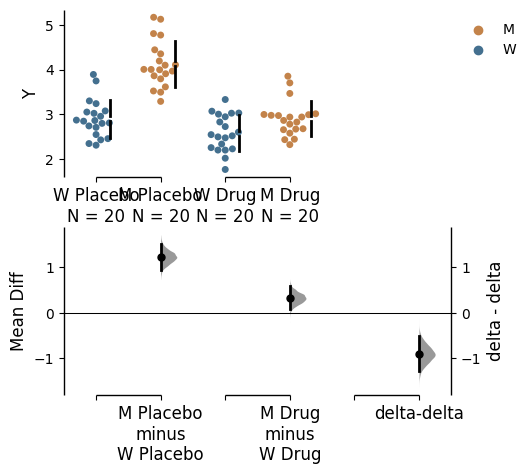

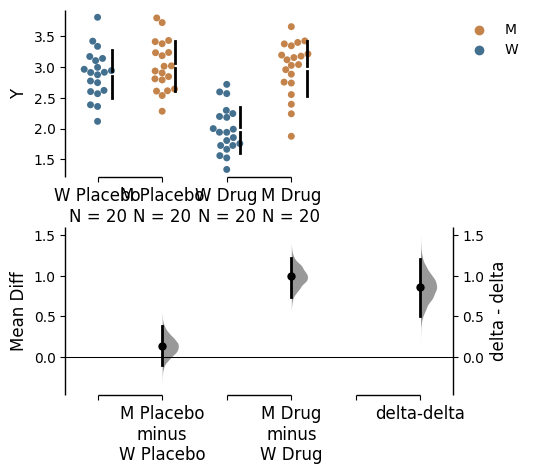

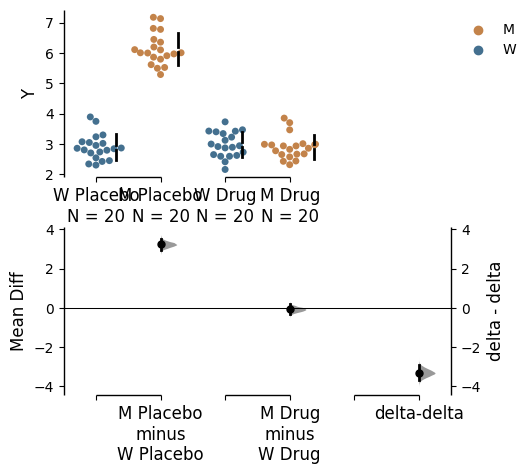

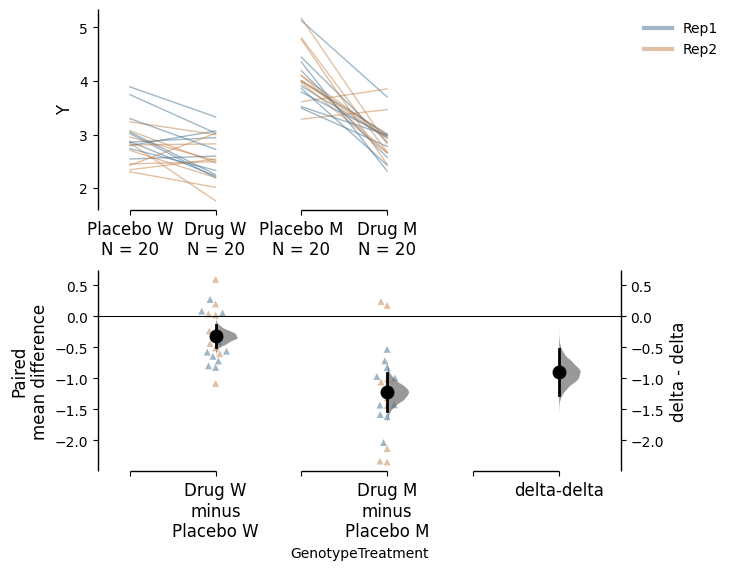

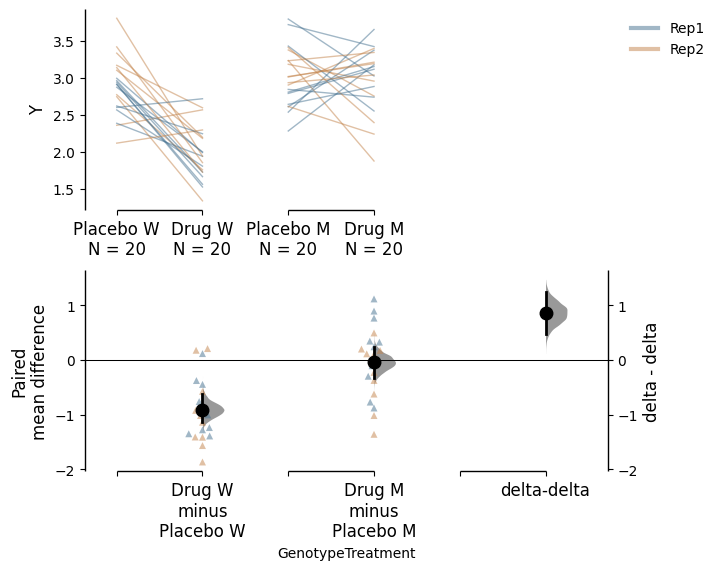

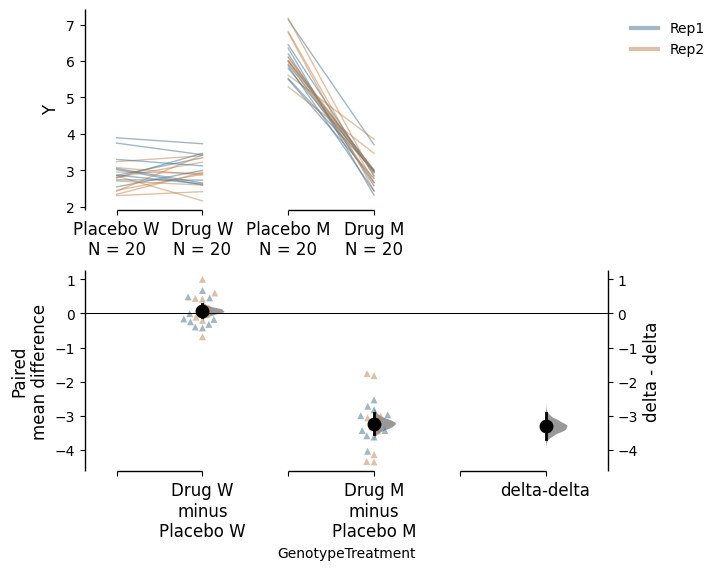

In [ ]:

f1 = unpaired_delta_01.mean_diff.plot(                  
                        contrast_label='Mean Diff',
                    fig_size = (5, 5),
                    raw_marker_size = 5,
                    es_marker_size = 5,
                    color_col='Genotype'
)


f2 = unpaired_delta_02.mean_diff.plot(                  
            contrast_label='Mean Diff',
            fig_size = (5, 5),
            raw_marker_size = 5,
            es_marker_size = 5,
            color_col='Genotype'
)


f3 = unpaired_delta_03.mean_diff.plot(                  
                    contrast_label='Mean Diff',
                    fig_size = (5, 5),
                    raw_marker_size = 5,
                    es_marker_size = 5,
                    color_col='Genotype'
)

p1 = paired_delta_01.mean_diff.plot()
p2 = paired_delta_02.mean_diff.plot()
p3 = paired_delta_03.mean_diff.plot()



# Plot all the delta delts plots into one plot for different comparisons of experiments under different conditions

## You can use the custom_palette argument to specify the colors you would like to indicate each experiment in a list ["gray", "blue", "green" ],
  >  The argument ``horizontal`` is a boolean input that changes the default orientation, if ``True`` the delta-delta values will be reflected on the x axis and the delta plots will be plotted horizontally. Additionally. the argument ``ylabel`` should be specified to specify the unit or the exact name of the measurement of experiments, for example "delta_deltas", the default is "value"

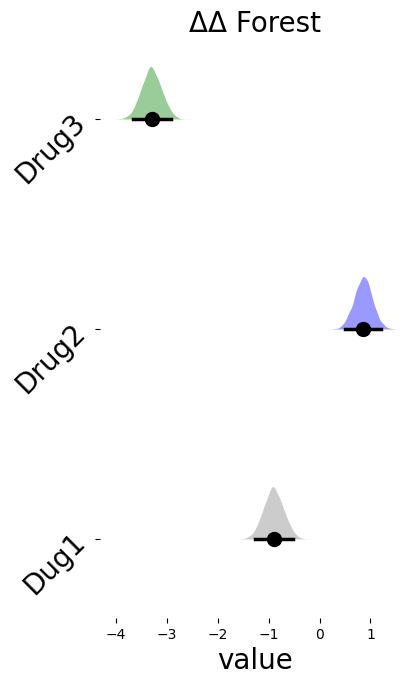

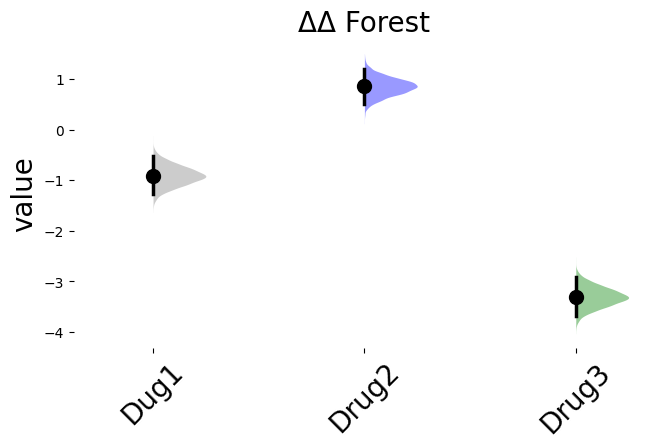

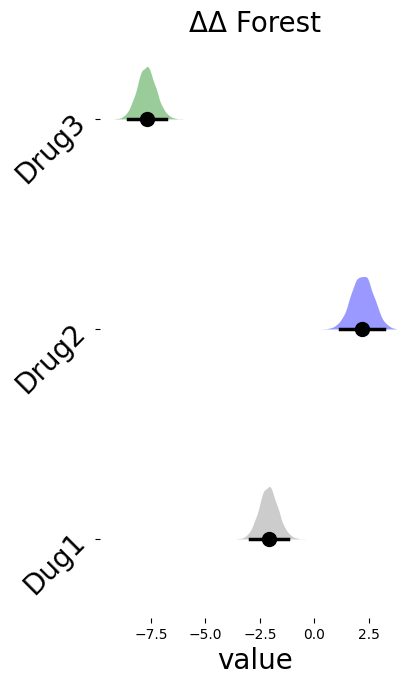

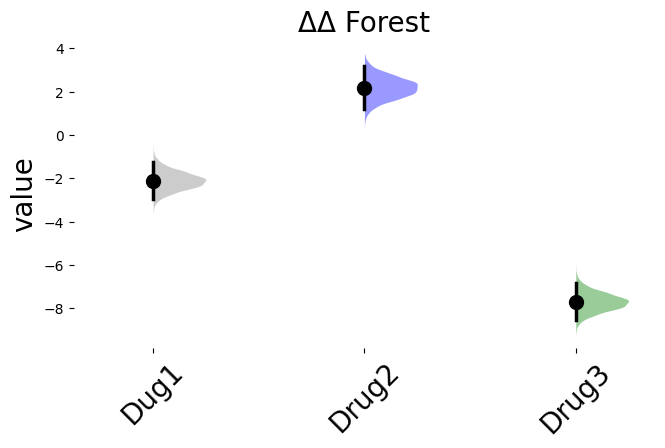

In [ ]:
forest1_horizontal = forest_plot(contrasts, contrast_labels =['Dug1', 'Drug2', 'Drug3'], custom_palette= ['gray', 'blue', 'green' ],horizontal=True)
forest1_vertical = forest_plot(contrasts, contrast_labels =['Dug1', 'Drug2', 'Drug3'], custom_palette= ['gray', 'blue', 'green' ])

forest2_horizontal = forest_plot(paired_contrasts, contrast_labels =['Dug1', 'Drug2', 'Drug3'], custom_palette= ['gray', 'blue', 'green' ],horizontal=True, effect_size='delta_g')
forest2_vertical = forest_plot(paired_contrasts, contrast_labels =['Dug1', 'Drug2', 'Drug3'], custom_palette= ['gray', 'blue', 'green' ], effect_size='delta_g')

# Using existing axis "ax" as the optional input to plot forest_plot with other kinds of dabest plots side by side or in other possible orientations, we will specify the x_labels that we want to indicate in a list of strings and parse it as the argument contrast_labels, for example ['Drug1', 'Drug2', 'Drug3'].

Text(0.5, 1.0, 'Paired')

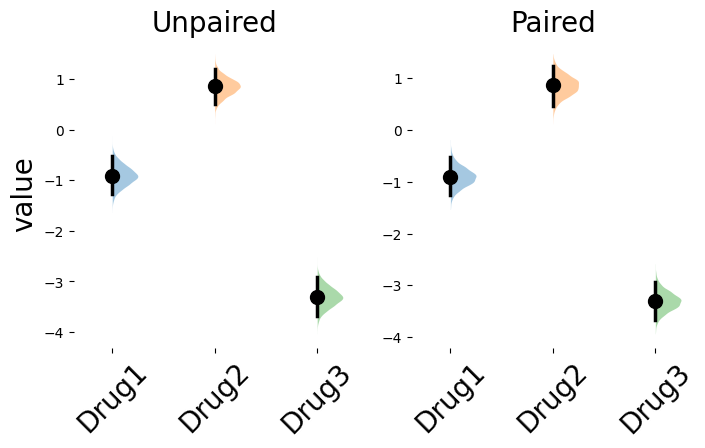

In [ ]:
f_forest_drug_profiles, axes  = plt.subplots(1, 2, figsize = [8, 4])
['Drug1', 'Drug2', 'Drug3']
forest_plot(contrasts, contrast_labels = ['Drug1', 'Drug2', 'Drug3'], ax = axes[0])
forest_plot(paired_contrasts, contrast_labels = ['Drug1', 'Drug2', 'Drug3'], ax = axes[1])
axes[0].set_title('Unpaired', fontsize = 20)
axes[1].set_ylabel('')
axes[1].set_title('Paired', fontsize = 20)


Text(0.0, 1.0, 'Forest plot')

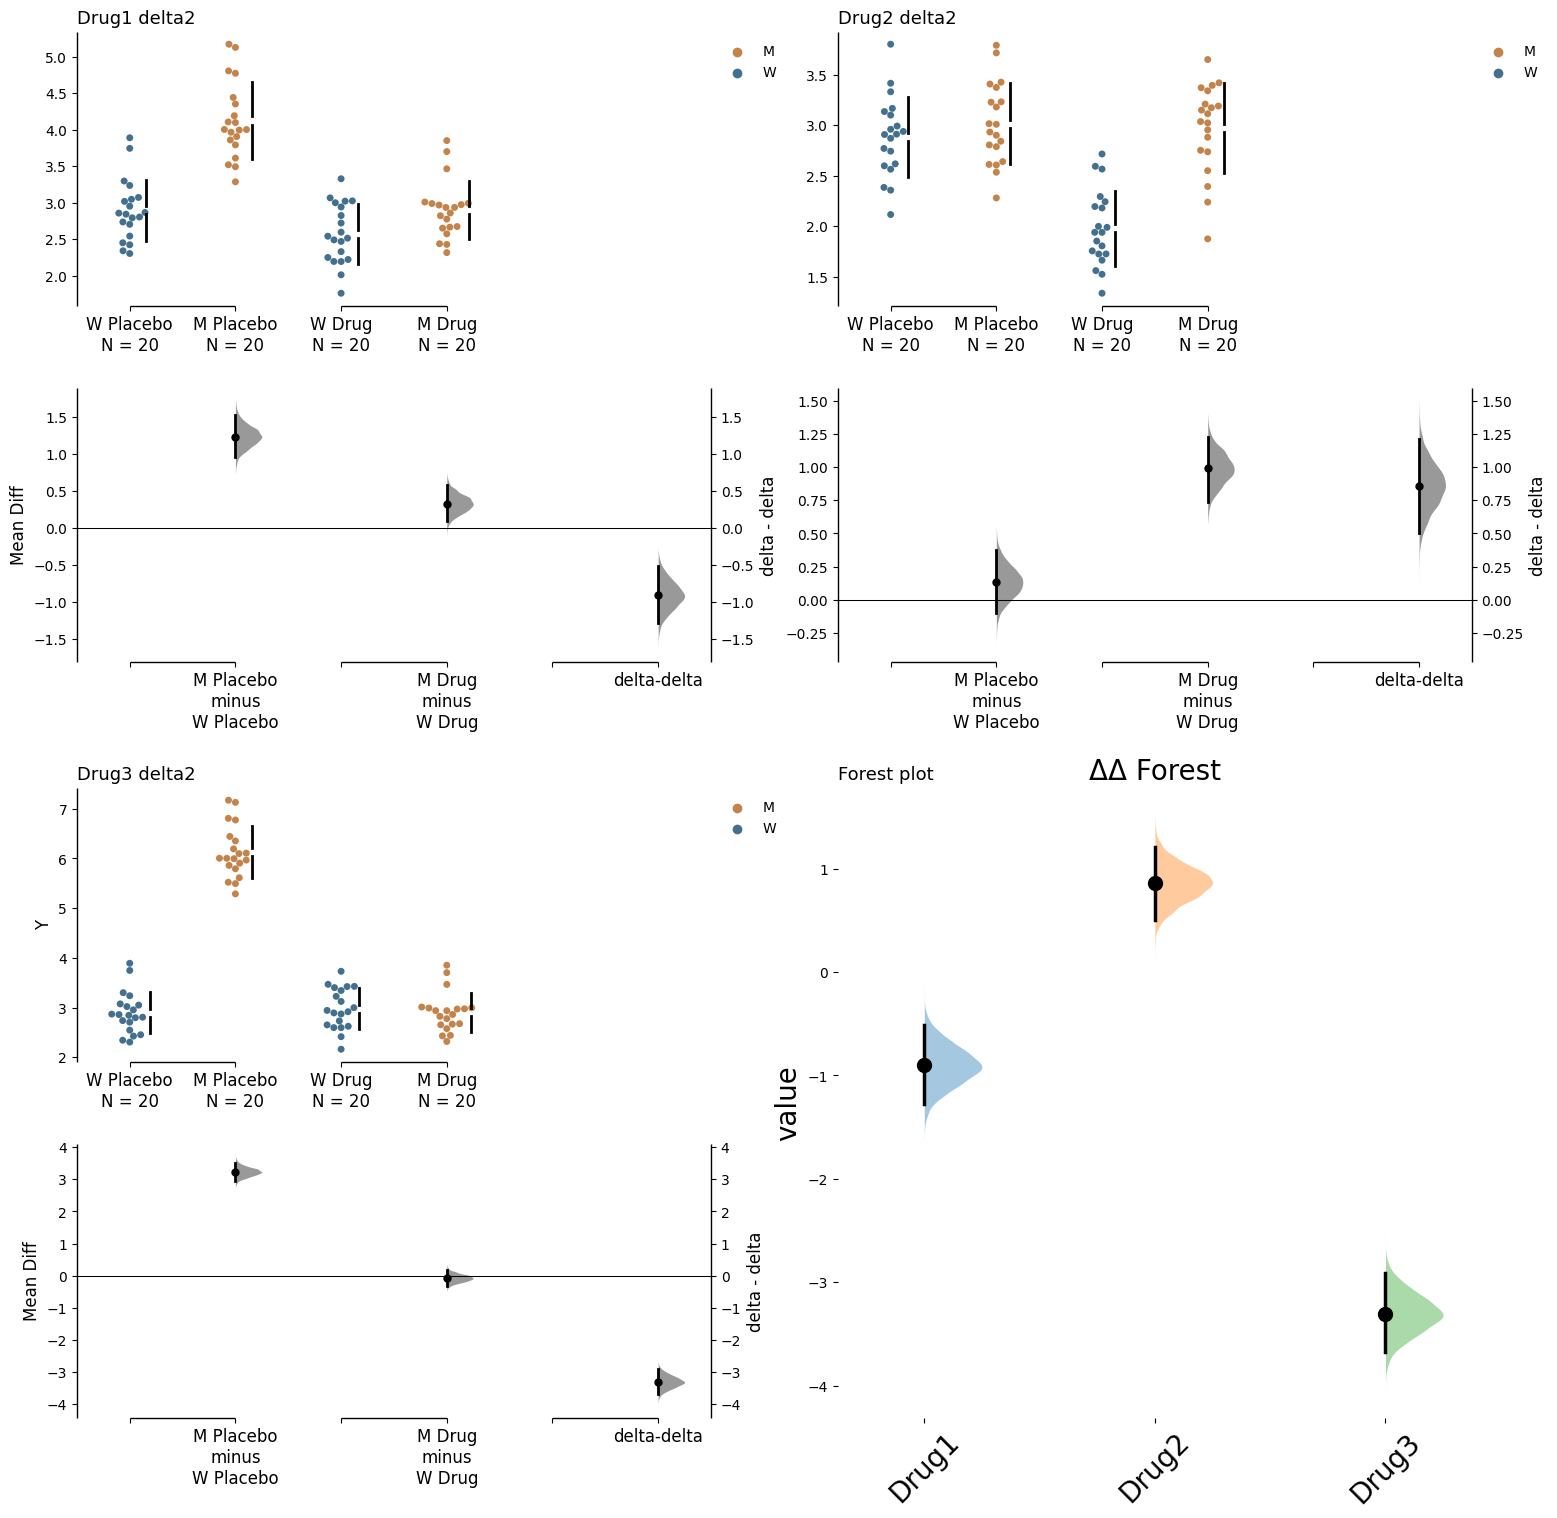

In [ ]:
f_forest_drug_profiles, axes  = plt.subplots(2, 2, figsize=[18, 18])
contrast_labels1 = ['Drug1', 'Drug2', 'Drug3']
unpaired_delta_01.mean_diff.plot(                  
                    contrast_label='Mean Diff',
                    fig_size = (5, 5),
                    raw_marker_size = 5,
                    es_marker_size = 5,
                    color_col='Genotype',
                    ax = axes[0,0]
)

unpaired_delta_02.mean_diff.plot(                  
            contrast_label='',
            fig_size = (5, 5),
            raw_marker_size = 5,
            es_marker_size = 5,
            color_col='Genotype',
            ax = axes[0,1]
)


unpaired_delta_03.mean_diff.plot(                  
                    contrast_label='Mean Diff',
                    fig_size = (5, 5),
                    raw_marker_size = 5,
                    es_marker_size = 5,
                    color_col='Genotype',
                    ax = axes[1,0]
)
forest_plot(contrasts, contrast_labels = contrast_labels1 , ax = axes[1,1])
axes[0,0].set_title('Drug1 delta2', fontsize = 13, loc='left')
axes[0,0].set_ylabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_title('Drug2 delta2', fontsize = 13, loc='left')
axes[1,0].set_title('Drug3 delta2', fontsize = 13, loc='left')
axes[0,1].set_ylabel('')
axes[1,1].set_title('Forest plot', fontsize = 13, loc='left') 

# ``forest_plot`` also supports mini-meta comparisons and with the contrast type changed to ``mini_meta_delta``

### We can simulate the datasets for unpaired mini_meta first

In [ ]:
from scipy.stats import norm # Used in generation of populations.

np.random.seed(9999) # Fix the seed to ensure reproducibility of results.
Ns = 20 # The number of samples taken from each population

# Create samples
c1 = norm.rvs(loc=3, scale=0.4, size=Ns)
c2 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
c3 = norm.rvs(loc=3.25, scale=0.4, size=Ns)

t1 = norm.rvs(loc=3.5, scale=0.5, size=Ns)
t2 = norm.rvs(loc=2.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=3, scale=0.75, size=Ns)


# Add a `gender` column for coloring the data.
females = np.repeat('Female', Ns/2).tolist()
males = np.repeat('Male', Ns/2).tolist()
gender = females + males

# Add an `id` column for paired data plotting.
id_col = pd.Series(range(1, Ns+1))

# Combine samples and gender into a DataFrame.
df_mini_meta01 = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                   'Control 2' : c2,     'Test 2' : t2,
                   'Control 3' : c3,     'Test 3' : t3,
                   'Gender'    : gender, 'ID'  : id_col
                  })


from scipy.stats import norm # Used in generation of populations.

np.random.seed(8888) # Fix the seed to ensure reproducibility of results.
Ns = 20 # The number of samples taken from each population

# Create samples
c1 = norm.rvs(loc=4, scale=0.3, size=Ns)
c2 = norm.rvs(loc=2, scale=0.75, size=Ns)
c3 = norm.rvs(loc=3.25, scale=0.45, size=Ns)

t1 = norm.rvs(loc=2, scale=0.5, size=Ns)
t2 = norm.rvs(loc=1.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=2.75, scale=0.4, size=Ns)


# Add a `gender` column for coloring the data.
females = np.repeat('Female', Ns/2).tolist()
males = np.repeat('Male', Ns/2).tolist()
gender = females + males

# Add an `id` column for paired data plotting.
id_col = pd.Series(range(1, Ns+1))

# Combine samples and gender into a DataFrame.
df_mini_meta02 = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                   'Control 2' : c2,     'Test 2' : t2,
                   'Control 3' : c3,     'Test 3' : t3,
                   'Gender'    : gender, 'ID'  : id_col
                  })

from scipy.stats import norm # Used in generation of populations.

np.random.seed(9999) # Fix the seed to ensure reproducibility of results.
Ns = 20 # The number of samples taken from each population

# Create samples
c1 = norm.rvs(loc=6, scale=0.4, size=Ns)
c2 = norm.rvs(loc=5.5, scale=0.75, size=Ns)
c3 = norm.rvs(loc=4.25, scale=0.45, size=Ns)

t1 = norm.rvs(loc=4.5, scale=0.5, size=Ns)
t2 = norm.rvs(loc=3.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=3, scale=0.9, size=Ns)


# Add a `gender` column for coloring the data.
females = np.repeat('Female', Ns/2).tolist()
males = np.repeat('Male', Ns/2).tolist()
gender = females + males

# Add an `id` column for paired data plotting.
id_col = pd.Series(range(1, Ns+1))

# Combine samples and gender into a DataFrame.
df_mini_meta03 = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                   'Control 2' : c2,     'Test 2' : t2,
                   'Control 3' : c3,     'Test 3' : t3,
                   'Gender'    : gender, 'ID'  : id_col
                  })

In [ ]:
contrast_mini_meta01 = dabest.load(data = df_mini_meta01,
                                   idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), 
                                   mini_meta=True)
contrast_mini_meta02 = dabest.load(data = df_mini_meta02,
                                    idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), 
                                    mini_meta=True)
contrast_mini_meta03 = dabest.load(data = df_mini_meta03,
                                   idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")),
                                    mini_meta=True)
contrasts_mini_meta = [contrast_mini_meta01, contrast_mini_meta02, contrast_mini_meta03]    
                              

### Use the contrast list and forest_plot to generate the figure

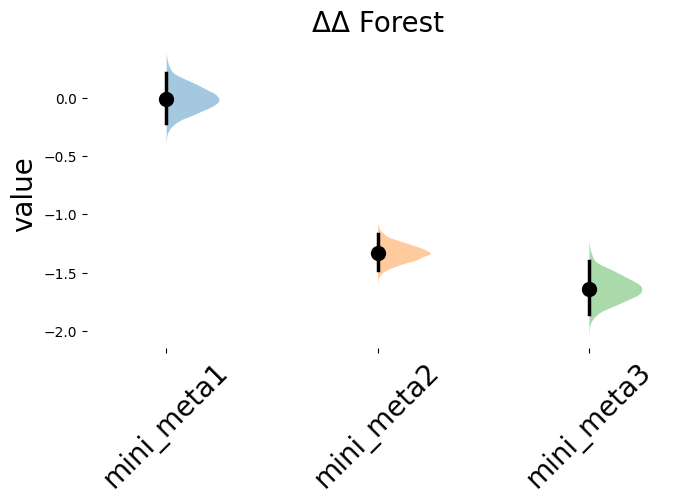

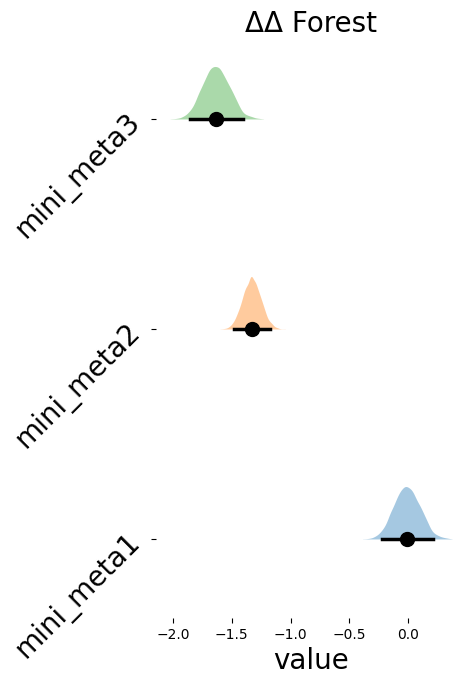

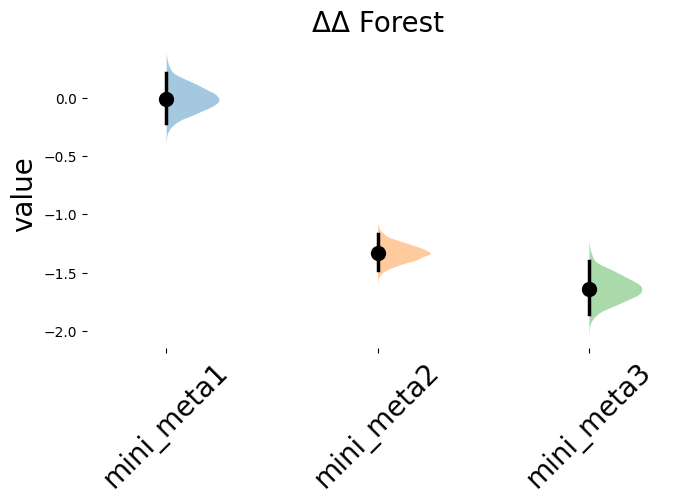

In [ ]:
forest_plot(contrasts_mini_meta, contrast_type='mini_meta', contrast_labels=['mini_meta1', 'mini_meta2', 'mini_meta3'], horizontal=True)
forest_plot(contrasts_mini_meta, contrast_type='mini_meta', contrast_labels=['mini_meta1', 'mini_meta2', 'mini_meta3'])